In [1]:
import numpy as np
import numpy.random as npr
from numpy.linalg import qr, svd, norm

import matplotlib.pyplot as plt
%matplotlib inline

import sys, os
sys.path.append(os.path.join(os.getcwd(), os.pardir))
import vmf

In [55]:
# Construct a basis for the orthogonal complement
# of the all-ones rows and all-ones columns
N = 4
Ws = []
for n in range(N):
    # row 
    Wnr = np.zeros((N,N))
    Wnr[n, :] = 1
    Ws.append(Wnr.ravel())
    
    # column
    Wnc = np.zeros((N,N))
    Wnc[:, n] = 1
    Ws.append(Wnc.ravel())
Ws = np.column_stack(Ws)

# We want the orthogonal complement of the columns of Ws
U, R = qr(Ws, mode='complete')

In [56]:
# Ws.shape = (N^2 x 2N) so U.shape = (N^2 x N^2)
# We expect the rank of U to be (N-1)^2 since that
# is the dimension of the hypersphere.
# 
print("bases of Ws")
for i in range(2*N-1):
    ui = U[:,i]
    print(abs(ui.dot(Ws)).sum())

print("")
print("bases of \perp(Ws)")
for i in range(2*N-1, N**2):
    ui = U[:,i]
    print(ui.dot(Ws).sum())

# Get the basis of the complement
# Shape = N^2 x (N-1)^2
U_compl = U[:,2*N-1:]
assert U_compl.shape == (N**2, (N-1)**2)

bases of Ws
4.0
3.87298334621
3.86436713232
3.70328039909
3.6514837167
3.34664010614
3.02371578407

bases of \perp(Ws)
8.04911692853e-16
-2.49800180541e-16
7.21644966006e-16
-1.4224732503e-16
1.43982048506e-16
-4.09394740331e-16
-1.38777878078e-16
1.38777878078e-17
-3.33066907388e-16


In [62]:
# Sweeeeeeeet... now let's project permutations onto the sphere
def project_perm_to_sphere(P):
    assert P.shape == (N,N)
    
    # Vectorize, center, project, reshape
    P = P.ravel()
    P = P - 1.0 / N * np.ones(N**2)
    Psi = U_compl.T.dot(P)    
    return Psi

def project_sphere_to_perm(Psi):
    assert Psi.shape == ((N-1)**2,)
    P = U_compl.dot(Psi)
    P = P + 1.0 / N * np.ones(N**2)
    P = P.reshape((N, N))
#     assert np.allclose(P.sum(0), 1.0)
#     assert np.allclose(P.sum(1), 1.0)
#     assert np.min(P) >= 0 - 1e-8
#     assert np.max(P) <= 1 + 1e-8
    return P

def random_permutation():
    perm = np.random.permutation(N)
    P = np.zeros((N,N))
    P[np.arange(N), perm] = 1
    return P

P = random_permutation()

Psi = project_perm_to_sphere(P)
# This vector should lie on a hypersphere of 
# radius \sqrt(N-1) in R^{(N-1)^2}
assert np.allclose(norm(Psi), np.sqrt(N-1))

Precon = project_sphere_to_perm(Psi)
assert np.allclose(P, Precon)

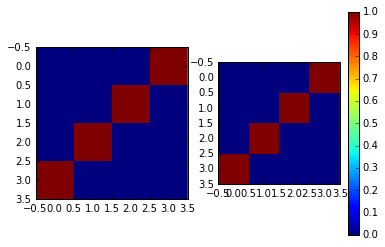

In [63]:
plt.figure()
plt.subplot(121)
plt.imshow(P, interpolation="none", vmin=0, vmax=1)

plt.subplot(122)
plt.imshow(Precon, interpolation="none", vmin=0, vmax=1)
plt.colorbar()

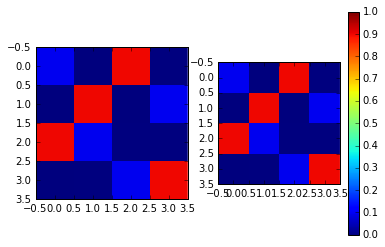

In [84]:
P1 = random_permutation()
P2 = random_permutation()
P = 0.9 * P1 + 0.1 * P2
Psi = project_perm_to_sphere(P)
# assert np.allclose(norm(Psi), np.sqrt(N-1))
Precon = project_sphere_to_perm(Psi)
assert np.allclose(P, Precon)

plt.figure()
plt.subplot(121)
plt.imshow(P, interpolation="none", vmin=0, vmax=1)

plt.subplot(122)
plt.imshow(Precon, interpolation="none", vmin=0, vmax=1)
plt.colorbar()

In [65]:
# Sample random points on sphere
mu = np.random.randn((N-1)**2)
mu /= norm(mu)

num_samples = 4
psis = vmf.sample_vMF(mu, kappa=1.0, num_samples=num_samples)
psis *= np.sqrt(N-1)
print(norm(psis, axis=1))

psis = npr.randn(num_samples, (N-1)**2)
psis /= norm(psis, axis=1, keepdims=True) 
psis *= np.sqrt(N-1)
print(norm(psis, axis=1))

Num iter:  1
Num iter:  1
Num iter:  1
Num iter:  1
[ 1.73205081  1.73205081  1.73205081  1.73205081]
[ 1.73205081  1.73205081  1.73205081  1.73205081]


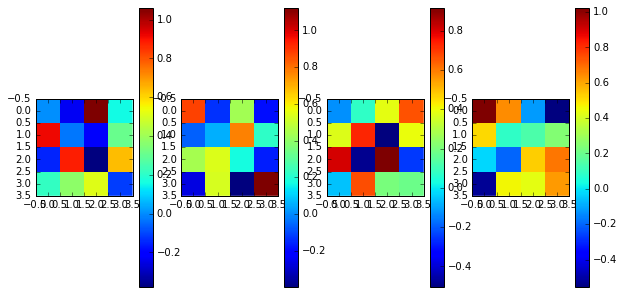

In [68]:
Ps = [project_sphere_to_perm(psi) for psi in psis]

plt.figure(figsize=(10,5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(Ps[i], interpolation="none")
    plt.colorbar()

In [82]:
N = 4
perm1 = np.arange(N)
P1 = np.zeros((N,N))
P1[np.arange(N), perm1] = 1

perm2 = np.concatenate((np.arange(1,N), [0]))
P2 = np.zeros((N,N))
P2[np.arange(N), perm2] = 1

P = 0.5 * P1 + 0.5 * P2
assert np.allclose(P.sum(0), 1.0)
assert np.allclose(P.sum(1), 1.0)

O = 1./N * np.ones((N,N))


print("sqrt(N-1):      ", np.sqrt(N-1))
print("||1/n - P1||_2: ", norm(O-P1))
print("||1/n - P2||_2: ", norm(O-P2))
print("||1/n - P||_2:  ", norm(O-P))

sqrt(N-1):       1.73205080757
||1/n - P1||_2:  1.73205080757
||1/n - P2||_2:  1.73205080757
||1/n - P||_2:   1.0
